*The codes were developed on Windows 10, and were not tested on other machines. Anaconda 5.2.0 is chosen as a Python interpreter.*

This notebook introduces the concept and methodology of generating variograms.

# Spatial Data Simulation

Let's say that you are a spatial data analyst of a gold mining company, and want to know the distribution of gold percentage over 100m x 100m mining area. To understand the characteritics of the rock formations, you take 100 random rock samples from the mining area, but obviously these 100 data points are not enough to estimate gold percentage over every single spatial locations in the area. So you analyze the available data (100 rock samples from random locations) and simulate full 2D-surface plot for gold percentage over the mining area.

![Simulation](https://github.com/aegis4048/Petroleum_Engineering/blob/master/Data%20Analysis/img/gold_transform.png?raw=true)

This 2D surface simulation from sparse spatial data is a sequential process that involves many complicated statistical techniques. 

Steps:

1. Plot variogram
2. Fit variogram model
3. Apply kriging
4. Apply simulation on top of Kriging
5. Run simulation multiple times and perform additioanl data analyses as needed

In this post, the concepts, theory, and methodology of plotting a **variogram** will be covered. 


# Basics of Variograms

> **Variogram** is a measure of dissimilarity over a distance. It shows how two data points are correlated from a spatial perspective, and provides useful insights when trying to estimate the value of an unknown location using collected sample data from other locations.

[Tobler's first law of geography](https://en.wikipedia.org/wiki/Tobler%27s_first_law_of_geography) states that "everything is related to everything else, but near things are more related than distant things." Variogram demonstates just that. It shows how correlation between two spatial data varies over distances. For example, terrains 1 km apart from each other are more likely to be similar than terrains 100 km apart from each other. Oil wells 500 ft apart from each other are more likely to show similar reservoir characteristics than oil wells 5000 ft apart from each other. 


In [93]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import math
%matplotlib notebook

In [94]:
data = pd.read_excel('sample_data/2D_Data.xlsx', sheet_name="variogram_sample")

x = data['x']
y = data['y']
z = data['z']

In [100]:
class Values2D:
    def __init__(self, values=None, azimuth=None):
        self.values = values
        self.azimuth = azimuth
        
    def __repr__(self):
        return("{}(values={}, azimuth={})".format(self.__class__.__name__, self.values, self.azimuth))
    
        
class Variogram2D:

    def __init__(self, x, y, z, dist_max, azi, lag_dist, azi_tol=None, lag_tol=None):
        
        # typical value of azimuth tolerance is +/- 22.5 degrees
        self.azi_tol = azi_tol if azi_tol is not None else 22.5 
        
        # typical lag tolerance is half of the lag distance
        self.lag_tol = lag_tol if lag_tol is not None else lag_dist / 2

        assert len(x) == len(y) == len(z), "x, y, and z must have the same dimension"
        assert 0 <= azi <= 360, "azimuth must have a range of [0, 360]"
        assert 0 <= self.azi_tol <= 90, "azimuth tolerance must have a range of [0, 90]"

        if azi == 90:
            self.isotropy = True
        else:
            self.isotropy = False
        
        self.dist_max = dist_max
        self.lag_dist = lag_dist

        self.npair = []
        self.sumsq = []
        self.gamma = []

        # number of data points
        self.n = len(x)

        # lag distances on which variogram gamma values will be computed
        self.lags = np.array([i * 5 for i in range(int(dist_max / lag_dist) + 1)])

        # 1-D distances between two points on a coordinate system
        self.dx = np.array([[x[i] - x[j] for j in range(self.n)] for i in range(self.n)])
        self.dy = np.array([[y[i] - y[j] for j in range(self.n)] for i in range(self.n)])

        # 2-D distances between two data points on a coordinate system
        self.distances = np.array(
            [[np.sqrt((x[i] - x[j]) ** 2 + (y[i] - y[j]) ** 2) for j in range(self.n)] for i in range(self.n)])

        # difference in angle between two data points (degrees)
        self.dazimuth = np.array([[self.calc_theta(i, j) for j in range(self.n)] for i in range(self.n)])

        # squared differences between two data points values at a certain lag distance
        self.pairwise_sq_diff = np.array([[(z[i] - z[j]) ** 2 for j in range(self.n)] for i in range(self.n)])

        # user defined azimuth in two directions. In case of isotropy, azimuth is the same for both directions
        if self.isotropy:
            self.azi = [self.ensure_positive_azimuth(azi), self.ensure_positive_azimuth(azi)]
        else:
            self.azi = [self.ensure_positive_azimuth(azi), self.ensure_positive_azimuth(azi + 90)]

        # variogram gamma values in two directions. They are the same for both directions in case of isotropy
        self.directional_compute()

    # ensures positive azimuth between two data points.
    # In variograms, positive y-axis of a 2-D plane is 0 degree azimuth. Azimuth increases clockwise
    def ensure_positive_azimuth(self, azi):
        if azi + self.azi_tol > 360:
            return azi - 180
        elif azi - self.azi_tol < 0:
            return azi + 180
        else:
            return azi

    def calc_theta(self, i, j):
        if self.dx[i, j] > 0:
            theta = np.degrees(np.pi / 2 - np.arctan(self.dy[i, j] / self.dx[i, j]))
        elif self.dx[i, j] < 0:
            theta = np.degrees(np.pi * 1.5 - np.arctan(self.dy[i, j] / self.dx[i, j]))
        else:
            if self.dy[i, j] > 0:
                theta = 0
            elif self.dy[i, j] < 0:
                theta = 180
            else:
                theta = 0
        return theta

    def is_within_azi_lag_tolerance(self, data_azi, data_lag, lag, azi):
        is_azi_tolerated = azi - self.azi_tol <= data_azi <= azi + self.azi_tol
        is_lag_tolerated = lag - self.lag_tol <= data_lag <= lag + self.lag_tol
        return is_azi_tolerated and is_lag_tolerated

    def calc_npairs(self, lag, azi):
        npairs = 0
        for i in range(self.n):
            for j in range(self.n):
                if self.is_within_azi_lag_tolerance(self.dazimuth[i, j], self.distances[i, j], lag, azi):
                    npairs += 1
        return npairs

    def calc_sumsq(self, lag, azi):
        sumsq = 0
        for i in range(self.n):
            for j in range(self.n):
                if self.is_within_azi_lag_tolerance(self.dazimuth[i, j], self.distances[i, j], lag, azi):
                    sumsq += self.pairwise_sq_diff[i, j]
        return sumsq
    
    def directional_compute(self):
        for i in range(2):
            npair = Values2D()
            sumsq = Values2D()
            gamma = Values2D()

            npair.values = np.array([self.calc_npairs(lag, self.azi[i]) for lag in self.lags])
            sumsq.values = np.array([self.calc_sumsq(lag, self.azi[i]) for lag in self.lags])
            gamma.values = np.divide(sumsq.values, npair.values * 2)

            npair.azimuth = self.azi[i]
            sumsq.azimuth = self.azi[i]
            gamma.azimuth = self.azi[i]

            self.npair.append(npair)
            self.sumsq.append(sumsq)
            self.gamma.append(gamma)    
            
    def __repr__(self):
        return("{}(dist_max={}, azi={}, lag_dist={}, azi_tol={}, lag_tol={}, isotropy={})".format(self.__class__.__name__, self.dist_max, self.azi, self.lag_dist, self.azi_tol, self.lag_tol, self.isotropy))
    
    

C:\Users\EricKim\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


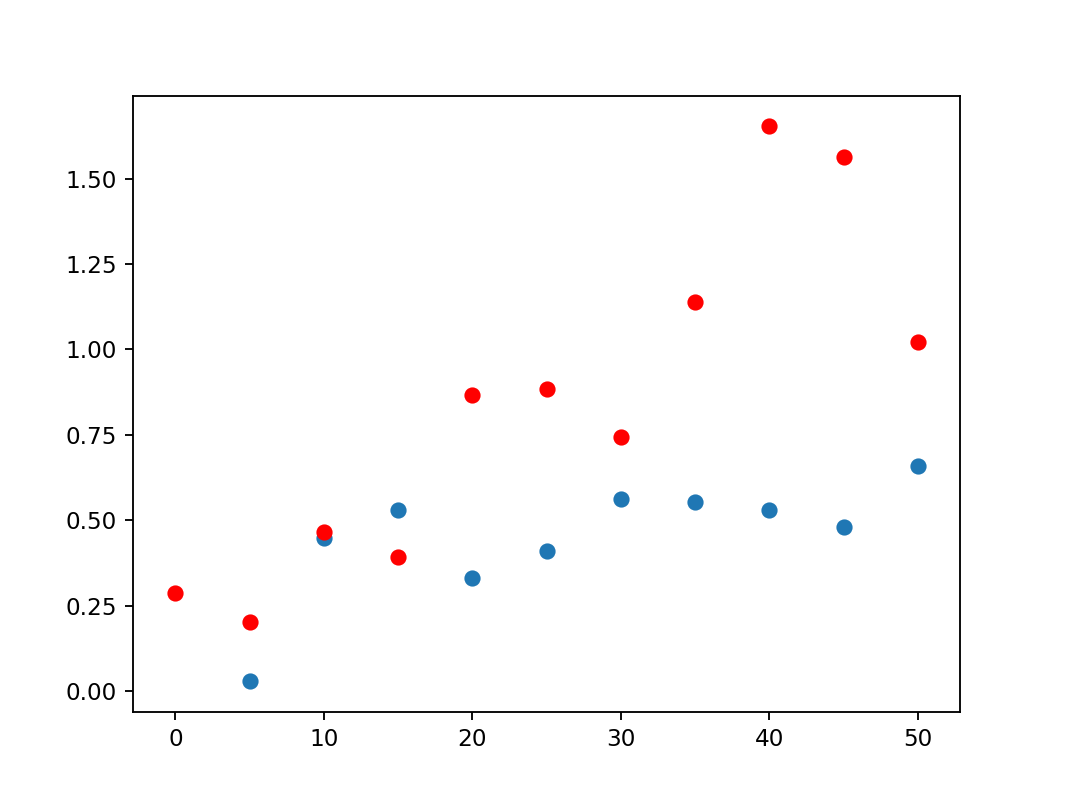

Variogram2D(dist_max=100, azi=[45, 135], lag_dist=10, azi_tol=22.5, lag_tol=5.0, isotropy=False)


In [101]:
temp = Variogram2D(x, y, z, 100, 45, 10)

gamma = temp.gamma
lags = temp.lags

fig = plt.figure()
ax = plt.axes()

ax.scatter(lags, gamma[0].values)
ax.scatter(lags, gamma[1].values, color='red')
plt.show()
print(temp)

In [102]:
temp.gamma[0]

Values2D(values=[       nan 0.02842238 0.44771005 0.52927372 0.33100152 0.41089933
 0.56078986 0.55384899 0.53100337 0.47918797 0.65771003], azimuth=45)